In [28]:
import sys
sys.path.insert(1,'..')
import learnHeat as lh
from importlib import reload
lh = reload(lh)
import pygsp as pg
import numpy as np
import random
import scores_table as scort
scort = reload(scort)
import matplotlib.pyplot as plt
import pickle

In [38]:
trial = np.load('trials2.npy')
trial += 1
experiments = 100
N = 30
tau0 = [0.5,1,2.5,4]
quantiles = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
windows = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5]
finesse = [5,10,16, 32, 128, 256, 1024]
alpha = 0.01
beta = 0.1
score_res = np.zeros([experiments,3,len(quantiles),4,2])
max_iter = 50
all_laplacians = np.zeros([experiments,6,N,N])
for i in range(experiments):
    L1 = lh.heat_graph_RBF(N,kappa=0.75,sigma=0.5)
    L3 = lh.heat_graph_ER(N)
    L4 = lh.heat_graph_BA(N)
    X1 = lh.create_deltas(L1,tau0)
    X3 = lh.create_deltas(L3,tau0)
    X4 = lh.create_deltas(L4,tau0)
    res1 = lh.learn_heat(X1,tau0=tau0,alpha=alpha,beta=beta,max_iter=max_iter)
    res3 = lh.learn_heat(X3,tau0=tau0,alpha=alpha,beta=beta,max_iter=max_iter)
    res4 = lh.learn_heat(X4,tau0=tau0,alpha=alpha,beta=beta,max_iter=max_iter)
    LL1 = res1["L"]
    LL1[abs(LL1)<0.001] = 0
    LL3 = res3["L"]
    LL3[abs(LL3)<0.001] = 0
    LL4 = res4["L"]
    LL1[abs(LL4)<0.001] = 0
    ground_laplacians = [L1,L3,L4]
    lapl = [LL1,LL3,LL4]
    learned_laplacians = lapl
    for A in range(3):
        all_laplacians[i,A,:,:] = ground_laplacians[A]
        all_laplacians[i,A+3,:,:] = lapl[A]
        
    # do the experiments, at random, quantiles in 0, 0.25, 0.5, 0.75
    # window at 0.01, 0.1, 0.25, 0.5, 0.75
    # finesse at 1000, 100, 10, 5
    for j in range(3):
        # do stuff
        for q in range(len(quantiles)):
            score_res[i,j,q,0,:] = scort.both_scores(lh.heat_quantile(learned_laplacians[j],quantiles[q]),ground_laplacians[j])
        for f in range(len(finesse)):
            score_res[i,j,f,1,:] = scort.both_scores(lh.heat_persistent(learned_laplacians[j],finesse[f]),ground_laplacians[j])
        for w in range(len(windows)):
            score_res[i,j,w,2,:] = scort.both_scores(lh.weight_clusters(learned_laplacians[j],windows[w]),ground_laplacians[j])

np.save(f"noparams_CONV_QUANT_PERS_{trial}_experiments{experiments}_N{N}_iter{max_iter}.npy",score_res)
np.save("trials2.npy",trial)
np.save(f"laplacians_{trial}",all_laplacians)


In [34]:
trial = np.load('trials2.npy')
trial += 1
experiments = 5
N = 40
tau0 = [0.5,1,2.5,4]
quantiles = [0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99]
windows = [0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5]
finesse = [5,10,16, 32, 128, 256, 1024]
alpha = 0
beta = 0
score_res2 = np.zeros([experiments,3,len(quantiles),4,2])
max_iter = 50
for i in range(experiments):
    L1 = lh.heat_graph_RBF(N,kappa=0.75,sigma=0.5)
    L3 = lh.heat_graph_ER(N)
    L4 = lh.heat_graph_BA(N)
    X1 = lh.create_deltas(L1,tau0)
    X3 = lh.create_deltas(L3,tau0)
    X4 = lh.create_deltas(L4,tau0)
    res1 = lh.learn_heat(X1,tau0=tau0,alpha=alpha,beta=beta,max_iter=max_iter)
    res3 = lh.learn_heat(X3,tau0=tau0,alpha=alpha,beta=beta,max_iter=max_iter)
    res4 = lh.learn_heat(X4,tau0=tau0,alpha=alpha,beta=beta,max_iter=max_iter)
    LL1 = res1["L"]
    LL3 = res3["L"]
    LL4 = res4["L"]
    ground_laplacians = [L1,L3,L4]
    learned_laplacians = [LL1,LL3,LL4]

    # do the experiments, at random, quantiles in 0, 0.25, 0.5, 0.75
    # window at 0.01, 0.1, 0.25, 0.5, 0.75
    # finesse at 1000, 100, 10, 5
    for j in range(3):
        # do stuff
        for q in range(len(quantiles)):
            score_res2[i,j,q,0,:] = scort.both_scores(lh.heat_quantile(learned_laplacians[j],quantiles[q]),ground_laplacians[j])
        for f in range(len(finesse)):
            score_res2[i,j,f,1,:] = scort.both_scores(lh.heat_persistent(learned_laplacians[j],finesse[f]),ground_laplacians[j])
        for w in range(len(windows)):
            score_res2[i,j,w,2,:] = scort.both_scores(lh.weight_clusters(learned_laplacians[j],windows[w]),ground_laplacians[j])

np.save(f"noparams_CONV_QUANT_PERS_{trial}_experiments{experiments}_N{N}_iter{max_iter}.npy",score_res)
np.save("trials2.npy",trial)

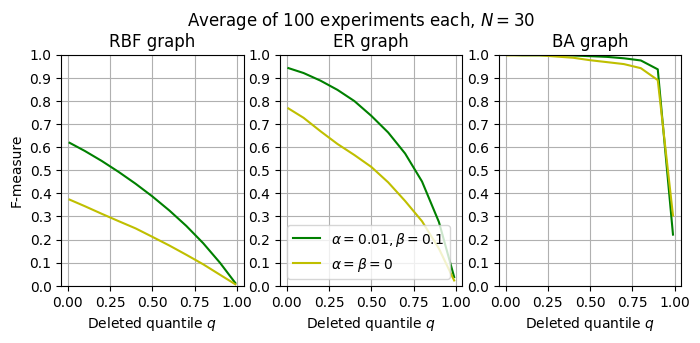

In [43]:
def plot_quantiles(check,check2,type):
    # plot the three graphs all quantiles
    fig, ax = plt.subplots(1,3,figsize=(8,3),sharex=True)
    fig.suptitle((r"Average of 100 experiments each, $N=30$"),y=1.03)
    titles = ["RBF graph","ER graph","BA graph"]
    for r in range(3):
        aux = np.mean(check[:,r,:,type,0],axis=0).reshape(-1)
        aux2 = np.mean(check2[:,r,:,type,0],axis=0).reshape(-1)
        ax[r].plot([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],aux[::-1],label=r"$\alpha=0.01,\beta=0.1$",color='g')
        ax[r].plot([0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.99],aux2[::-1],label=r"$\alpha=\beta=0$",color='y')
        ax[r].set_title(titles[r])
        ax[r].set_xlabel("Deleted quantile $q$")
        ax[r].set_xticks(np.linspace(0,1,5))
        ax[r].set_ylim(0,1)
        ax[r].set_yticks(np.linspace(0,1,11))
        ax[r].grid(True)
    ax[0].set_ylabel("F-measure")
    ax[1].legend()
plot_quantiles(score_res,score_res2,type=0)

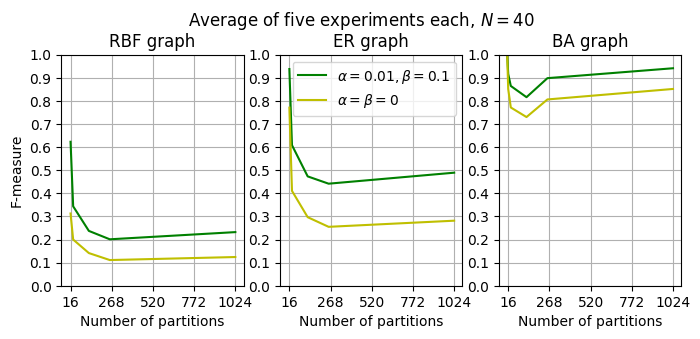

In [40]:
def plot_quantiles(check,check2,type,eje_x):
    # plot the three graphs all quantiles
    fig, ax = plt.subplots(1,3,figsize=(8,3),sharex=True)
    fig.suptitle((r"Average of five experiments each, $N=40$"),y=1.03)
    titles = ["RBF graph","ER graph","BA graph"]
    for r in range(3):
        aux = np.mean(check[:,r,0:len(eje_x),type,0],axis=0).reshape(-1)
        aux2 = np.mean(check2[:,r,0:len(eje_x),type,0],axis=0).reshape(-1)
        ax[r].plot(eje_x,aux,label=r"$\alpha=0.01,\beta=0.1$",color='g')
        ax[r].plot(eje_x,aux2,label=r"$\alpha=\beta=0$",color='y')
        ax[r].set_title(titles[r])
        ax[r].set_xlabel("Number of partitions")
        ax[r].set_ylim(0,1)
        ax[r].set_xticks(np.linspace(16,1024,5))
        ax[r].set_yticks(np.linspace(0,1,11))
        ax[r].grid(True)
    ax[0].set_ylabel("F-measure")
    ax[1].legend()
plot_quantiles(score_res,score_res2,1,[10,16, 32, 128, 256, 1024])

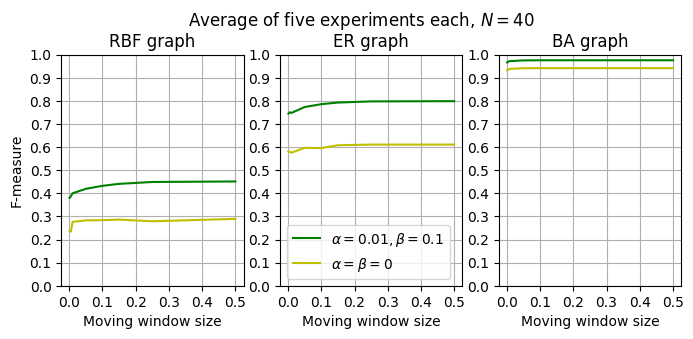

In [41]:
def plot_quantiles(check,check2,type,eje_x):
    # plot the three graphs all quantiles
    fig, ax = plt.subplots(1,3,figsize=(8,3),sharex=True)
    fig.suptitle((r"Average of five experiments each, $N=40$"),y=1.03)
    titles = ["RBF graph","ER graph","BA graph"]
    for r in range(3):
        aux = np.mean(check[:,r,0:len(eje_x),type,0],axis=0).reshape(-1)
        aux2 = np.mean(check2[:,r,0:len(eje_x),type,0],axis=0).reshape(-1)
        ax[r].plot(eje_x,aux,label=r"$\alpha=0.01,\beta=0.1$",color='g')
        ax[r].plot(eje_x,aux2,label=r"$\alpha=\beta=0$",color='y')
        ax[r].set_title(titles[r])
        ax[r].set_xlabel("Moving window size")
        ax[r].set_ylim(0,1)
        ax[r].set_xticks(np.linspace(0,0.5,6))  
        ax[r].set_yticks(np.linspace(0,1,11))
        ax[r].grid(True)
    ax[0].set_ylabel("F-measure")
    ax[1].legend()
plot_quantiles(score_res,score_res2,2,[0.001, 0.005, 0.01, 0.05, 0.1, 0.15, 0.25, 0.5])